#Import Tweets Data 


1.   Import Tweets from sntwitter API (https://github.com/JustAnotherArchivist/snscrape)

2.   Clean up data - Remove special characters, emojis, memes in each tweets

In [1]:
import numpy as np
import pandas as pd
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
import matplotlib.pyplot as mlpt
import csv
# !pip install snscrape
import datetime as dt
import snscrape.modules.twitter as sntwitter

In [2]:
from tqdm import tqdm

In [3]:
tweets = []
# Using TwitterSearchScraper to scrape data and append tweets to list
for i,tweet in tqdm(enumerate(sntwitter.TwitterSearchScraper('#Black Lives Matter  since:2022-01-01 until:2022-03-30','corona lang:en').get_items())):
    tweets.append([tweet.date,  tweet.content])

386it [00:25, 15.22it/s]


In [6]:
tweets = pd.DataFrame(tweets, columns=['Date', 'Tweets'])

In [7]:
data=tweets
cdata=pd.DataFrame(columns=['Date','Tweets'])
index=0
for index,row in data.iterrows():
    stre=row["Tweets"]
    my_new_string = re.sub('[^ a-zA-Z0-9]', '', stre)
    cdata.sort_index()
    cdata.at[index,'Date']=row["Date"]
    cdata.at[index,'Tweets']=my_new_string
    index=index+1
tweets=cdata
tweets['Date'] = tweets['Date'].astype('datetime64[ns]')
tweets["Date"]=tweets["Date"].dt.date

In [8]:
tweets.head()

,Date,Tweets
0,2022-03-29,Dedicated to Martin Luther King Jr Humans vi...
1,2022-03-29,Have we been able to DEFINEwhat a MAN is yetTh...
2,2022-03-29,Dedicated to Martin Luther King Jr Humans vi...
3,2022-03-28,JUST SITTING HERE WATCHING THE WORLD CONDONE A...
4,2022-03-28,ZakReckless DiscussingFilm chris rock I guess ...


#Sentiment Analysis for Tweets

Sentiment Analysis is a process of â€˜computationallyâ€™ evaluating whether a piece of text is positive, negative or neutral. In our case, conducting sentiment analysis on tweets help determine the public's moods towards BLM(Black Lives Matter) topic.
1.   **VADER (Valence Aware Dictionary and Entiment Reasoner)**

```
"VADER is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed
in social media. A sentiment lexicon is a list of lexical features (e.g., words) which are generally labeled
according to their semantic orientation aseither positive or negative. VADER not only tells about the Positivity
and Negativity score but also tells us about how positive or negative a sentiment is." (GreeksforGreeks)
```
2.   **Reference**
 
  Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

In [9]:
# !pip install vaderSentiment
# !pip install pyspark

In [4]:
import pyspark as spark
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from pyspark.sql.types import *
from pyspark.sql import SQLContext
from pyspark.sql.functions import col,udf,monotonically_increasing_id,unix_timestamp,round,avg
import re
sc = spark.SparkContext()
sql = spark.SQLContext(sc)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/02 21:22:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [9]:
FullDataTw=sql.createDataFrame(tweets)
FullDataTw = FullDataTw.dropna()
FullDataTw.select(monotonically_increasing_id().alias("rowId"),"*")
 #setting column names of Twitter dataset
CleanDF = FullDataTw.withColumnRenamed('Tweets', 'Tweet')
CleanDF = FullDataTw.withColumnRenamed('Date', 'Date_Time')
analyser = SentimentIntensityAnalyzer()
def senti_score_udf(sentence):
    snt = analyser.polarity_scores(sentence)
    return ([snt['neg'], snt['neu'], snt['pos'], snt['compound']])
func_udf2 = udf(senti_score_udf, ArrayType(FloatType()))
CleanDF = CleanDF.withColumn('p_neg', func_udf2(CleanDF['Tweets'])[0])
CleanDF = CleanDF.withColumn('p_neu', func_udf2(CleanDF['Tweets'])[1])
CleanDF = CleanDF.withColumn('p_pos', func_udf2(CleanDF['Tweets'])[2])
CleanDF = CleanDF.withColumn('p_comp', func_udf2(CleanDF['Tweets'])[3])
CleanDF.show(120)
CleanDF.toPandas().to_csv('sen.csv')

+----------+--------------------+-----+-----+-----+-------+
| Date_Time|              Tweets|p_neg|p_neu|p_pos| p_comp|
+----------+--------------------+-----+-----+-----+-------+
|2022-03-29|Dedicated to Mart...|  0.0|0.773|0.227| 0.4767|
|2022-03-29|Have we been able...|0.124|0.799|0.076|-0.6268|
|2022-03-29|Dedicated to Mart...|  0.0|0.773|0.227| 0.4767|
|2022-03-28|JUST SITTING HERE...|0.204|0.705|0.092|-0.8029|
|2022-03-28|ZakReckless Discu...|0.094|0.806|  0.1|-0.2023|
|2022-03-28|Living my own lif...|  0.0|0.916|0.084| 0.0258|
|2022-03-28|jemelehill Im in ...|  0.0|0.894|0.106| 0.4215|
|2022-03-28|thetimeline256 In...|0.156|0.808|0.036| -0.694|
|2022-03-28|Racism is what se...|0.296|0.662|0.042| -0.836|
|2022-03-28|Dedicated to Mart...|  0.0|0.773|0.227| 0.4767|
|2022-03-28|BLACK LIVES MATTE...|  0.0|0.686|0.314| 0.2103|
|2022-03-27|jemelehill nhanna...|  0.0|0.872|0.128| 0.0516|
|2022-03-27|Dedicated to Mart...|  0.0|0.773|0.227| 0.4767|
|2022-03-27|Dedicated to Mart...|  0.0|0

 **Categorize Sentiments**
Once getting the sentiment score for each Tweets, we put them into categories. 

  $$\bar{P_{comp}} = \frac{1}{n}\sum_{i=1}^{N}P_{{comp}_i}$$

  $$\sigma_{P_{comp}}=\sqrt{\frac{1}{n}{\sum_{k=1}^n(P_{{comp}_i}-\bar{P_{comp}})^2}}$$

  $$Negative \ Sentiment : \bar{P_{comp}}-2\sigma_{P_{comp}}<P_{comp}<\bar{P_{comp}}-\sigma_{P_{comp}}$$
   
  $$Positive\  Sentiment: \bar{P_{comp}}+2\sigma_{P_{comp}}>P_{comp}>\bar{P_{comp}}+\sigma_{P_{comp}}$$

  $$Neutral \ Sentiment: [\bar{P_{comp}}-\sigma_{P_{comp}} \ ,\bar{P_{comp}}+\sigma_{P_{comp}}\ ]$$

  $$Extremely Negative \ Sentiment: [P<\bar{P_{comp}}-2\sigma_{P_{comp}} ]$$

  $$Extremely Postive \ Sentiment: [P>\bar{P_{comp}}+2\sigma_{P_{comp}} ]$$

In [10]:
tw=pd.read_csv("sen.csv")
tw=tw.drop(columns=["Unnamed: 0"])
tw["length"]=""
i=0
# iterate through the csv file 
for val in tw["Tweets"]: 
  val = str(val) 
  tokens = val.split() 
  tw["length"][i]=len(tokens)
  i=i+1
tw=tw.drop(columns=["p_neg","p_neu","p_pos"])

In [11]:
tw["p_comp"].describe()
mean=tw["p_comp"].mean()
std=tw["p_comp"].std()
tw["sentiment"]=""
i=0
for val in tw["p_comp"]: 
  if val> mean+2*std:
    tw["sentiment"][i]="extremely positive"
  if val< mean-2*std:
    tw["sentiment"][i]="extremely negative"
  if val>mean+std and val<mean+2*std:
    tw["sentiment"][i]="positive"
  if val<mean-std and val>mean-2*std:
    tw["sentiment"][i]="negative"
  if val>mean-std and val<mean+std:
    tw["sentiment"][i]="neutral"
  i=i+1

In [12]:
tw

,Date_Time,Tweets,p_comp,length,sentiment
0,2022-03-29,Dedicated to Martin Luther King Jr Humans vi...,0.4767,16,neutral
1,2022-03-29,Have we been able to DEFINEwhat a MAN is yetTh...,-0.6268,38,negative
2,2022-03-29,Dedicated to Martin Luther King Jr Humans vi...,0.4767,16,neutral
3,2022-03-28,JUST SITTING HERE WATCHING THE WORLD CONDONE A...,-0.8029,44,negative
4,2022-03-28,ZakReckless DiscussingFilm chris rock I guess ...,-0.2023,28,neutral
...,...,...,...,...,...
381,2022-01-02,Dedicated to Desmond Tutu Humans via pensign...,0.4767,14,neutral
382,2022-01-02,Dedicated to Desmond Tutu Humans via pensign...,0.4767,14,neutral
383,2022-01-01,Here Glenn Loury addresses Black Lives Matter ...,-0.9231,34,negative
384,2022-01-01,Dedicated to Desmond Tutu Humans via pensign...,0.4767,14,neutral


# Exercise2

#### Crawl data from twitter with another topic and do sentiment analysis on the data, after you get the results, try to use graphs to visualize the sentiment analysis results (any type of graph that could satisfy your purpose)

## Tweets are crawled for the sentence: "Stop Asian Hate" for 1 month

In [14]:
tweets = []
# Using TwitterSearchScraper to scrape data and append tweets to list
for i,tweet in tqdm(enumerate(sntwitter.TwitterSearchScraper('Stop Asian Hate  since:2022-01-01 until:2022-01-30','corona lang:en').get_items())):
    tweets.append([tweet.date,  tweet.content])

2585it [02:10, 19.86it/s]


In [16]:
tweets = pd.DataFrame(tweets, columns=['Date', 'Tweets'])
data=tweets
cdata=pd.DataFrame(columns=['Date','Tweets'])
index=0
for index,row in data.iterrows():
    stre=row["Tweets"]
    my_new_string = re.sub('[^ a-zA-Z0-9]', '', stre)
    cdata.sort_index()
    cdata.at[index,'Date']=row["Date"]
    cdata.at[index,'Tweets']=my_new_string
    index=index+1
tweets=cdata
tweets['Date'] = tweets['Date'].astype('datetime64[ns]')
tweets["Date"]=tweets["Date"].dt.date

In [17]:
FullDataTw=sql.createDataFrame(tweets)
FullDataTw = FullDataTw.dropna()
FullDataTw.select(monotonically_increasing_id().alias("rowId"),"*")
 #setting column names of Twitter dataset
CleanDF = FullDataTw.withColumnRenamed('Tweets', 'Tweet')
CleanDF = FullDataTw.withColumnRenamed('Date', 'Date_Time')
analyser = SentimentIntensityAnalyzer()
def senti_score_udf(sentence):
    snt = analyser.polarity_scores(sentence)
    return ([snt['neg'], snt['neu'], snt['pos'], snt['compound']])
func_udf2 = udf(senti_score_udf, ArrayType(FloatType()))
CleanDF = CleanDF.withColumn('p_neg', func_udf2(CleanDF['Tweets'])[0])
CleanDF = CleanDF.withColumn('p_neu', func_udf2(CleanDF['Tweets'])[1])
CleanDF = CleanDF.withColumn('p_pos', func_udf2(CleanDF['Tweets'])[2])
CleanDF = CleanDF.withColumn('p_comp', func_udf2(CleanDF['Tweets'])[3])
CleanDF.show(120)
CleanDF.toPandas().to_csv('sen.csv')

+----------+--------------------+-----+-----+-----+-------+
| Date_Time|              Tweets|p_neg|p_neu|p_pos| p_comp|
+----------+--------------------+-----+-----+-----+-------+
|2022-01-29|NYCMayor Come on ...|0.363|0.605|0.032|-0.9628|
|2022-01-29|heyafricans amina...|0.663|0.337|  0.0|-0.7096|
|2022-01-29|Hate against Asia...|0.242|0.758|  0.0|-0.8625|
|2022-01-29|People act so fak...|0.374|0.569|0.057|-0.9318|
|2022-01-29|BuzzFeedCeleb Sto...|0.747|0.253|  0.0|-0.7096|
|2022-01-29|50 volunteers cam...|  0.2|0.593|0.207| 0.1027|
|2022-01-29|TeagueisTrash yoo...|0.639|0.361|  0.0|-0.9423|
|2022-01-29|CentristRally18 y...|0.348|0.619|0.033|-0.9657|
|2022-01-29|A ver blinks y kp...|0.147|0.853|  0.0|-0.7964|
|2022-01-29|Noa llamas las st...|0.371|0.629|  0.0|-0.7096|
|2022-01-29|Impact of so call...|0.277|0.596|0.127|-0.8707|
|2022-01-29|Impact of so call...|0.304|0.574|0.122|-0.9013|
|2022-01-29|Comedy is subject...| 0.21|0.587|0.203|-0.1015|
|2022-01-29|DIGITALG00N But i...|0.444|0

In [18]:
tw=pd.read_csv("sen.csv")
tw=tw.drop(columns=["Unnamed: 0"])
tw["length"]=""
i=0
# iterate through the csv file 
for val in tw["Tweets"]: 
  val = str(val) 
  tokens = val.split() 
  tw["length"][i]=len(tokens)
  i=i+1
tw=tw.drop(columns=["p_neg","p_neu","p_pos"])

In [19]:
# tw["p_comp"].describe()
mean=tw["p_comp"].mean()
std=tw["p_comp"].std()
tw["sentiment"]=""
i=0
for val in tw["p_comp"]: 
  if val> mean+2*std:
    tw["sentiment"][i]="extremely positive"
  if val< mean-2*std:
    tw["sentiment"][i]="extremely negative"
  if val>mean+std and val<mean+2*std:
    tw["sentiment"][i]="positive"
  if val<mean-std and val>mean-2*std:
    tw["sentiment"][i]="negative"
  if val>mean-std and val<mean+std:
    tw["sentiment"][i]="neutral"
  i=i+1

In [58]:
tw['Date_Time'] = pd.to_datetime(tw['Date_Time'], format=r'%Y-%m%d')
dt_grp = tw.groupby(by='Date_Time')

In [59]:
'negative' in tw['sentiment'].value_counts().index

True

In [60]:
alsmtcs = tw['sentiment'].value_counts().index

In [61]:
iterDic = dict()
for dayMth, df in tqdm(dt_grp):
    srssent = df['sentiment'].value_counts()
    tmpdic = dict()
    for smtc in alsmtcs:
        if smtc in srssent.index:
            tmpdic[smtc] = srssent[smtc]
        else:
            tmpdic[smtc] = 0

    iterDic[dayMth] = tmpdic

100%|██████████| 29/29 [00:00<00:00, 1944.07it/s]


In [62]:
dfsmtcJan = pd.DataFrame(iterDic)
dfsmtcJan

,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,2022-01-10,...,2022-01-20,2022-01-21,2022-01-22,2022-01-23,2022-01-24,2022-01-25,2022-01-26,2022-01-27,2022-01-28,2022-01-29
neutral,29,70,63,53,50,46,41,51,79,50,...,120,106,144,64,70,53,79,63,86,185
positive,5,4,4,4,4,0,5,3,6,2,...,10,14,11,9,3,4,5,5,8,20
extremely positive,3,4,5,3,3,2,9,11,5,3,...,8,6,6,1,3,3,4,1,8,18
negative,0,0,0,0,0,0,0,0,0,0,...,0,1,2,0,0,0,0,1,0,1


In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter

## Below Figure shows how the daily count of different semantic change over time

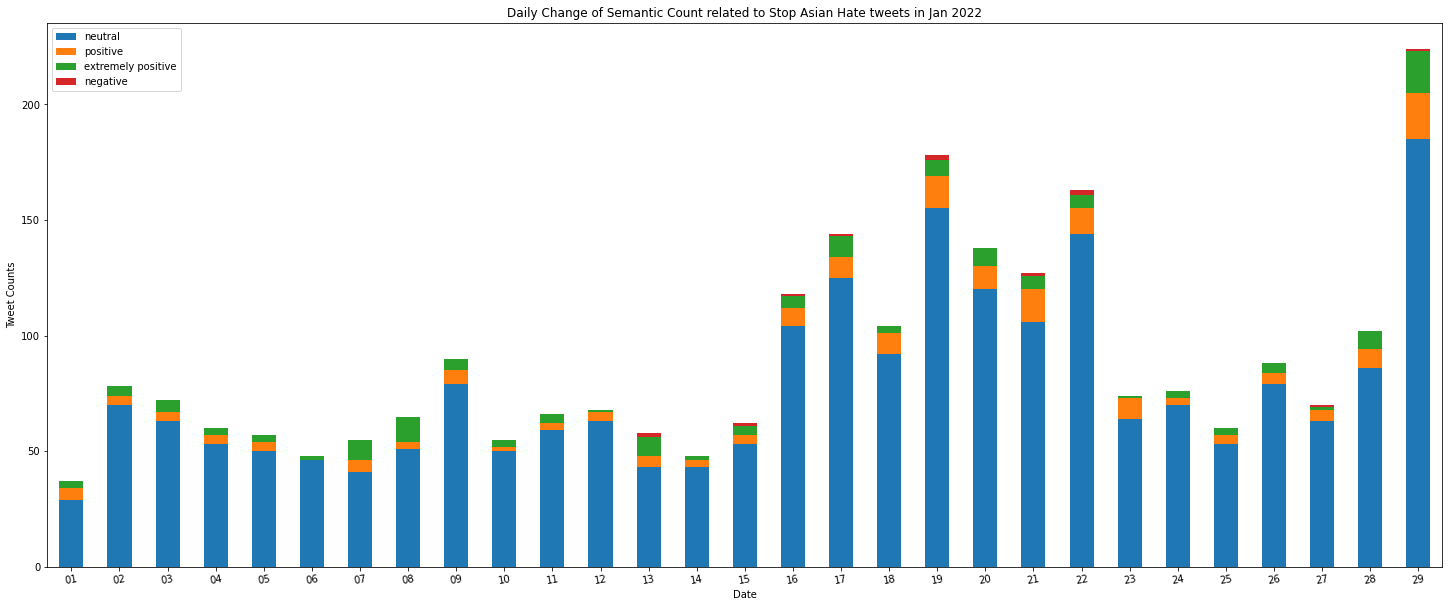

In [78]:
fig, ax = plt.subplots(figsize= (25,10))
# ax.plot

dfsmtcJan.transpose().plot(kind='bar',stacked=True, ax= ax)
myFmt = DateFormatter("%d")
ax.xaxis.set_major_formatter(myFmt)

ax.set_title("Daily Change of Semantic Count related to Stop Asian Hate tweets in Jan 2022")
ax.set_xlabel("Date")
ax.set_ylabel("Tweet Counts")
plt.xticks(rotation=10)
plt.show()
